In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

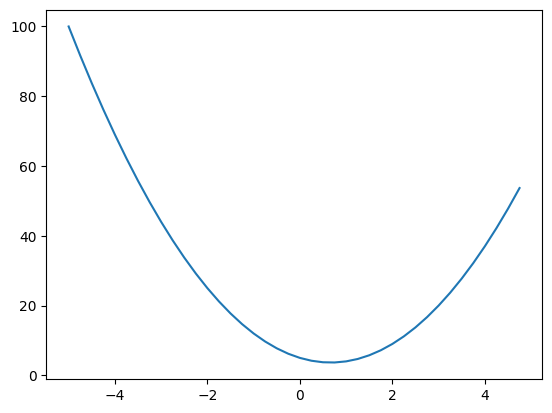

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

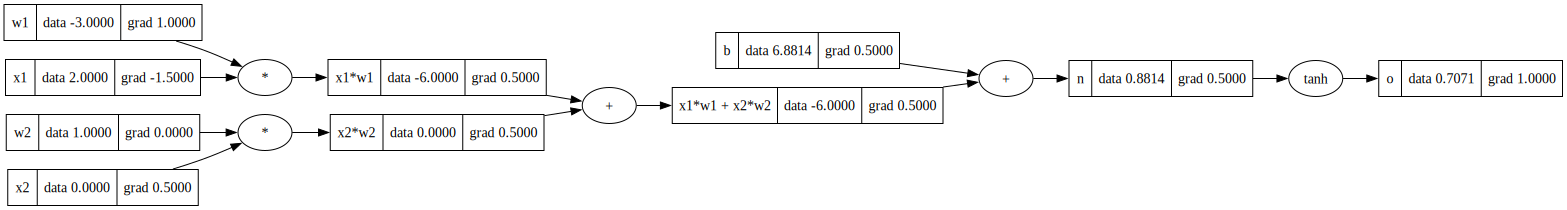

In [11]:
draw_dot(o)

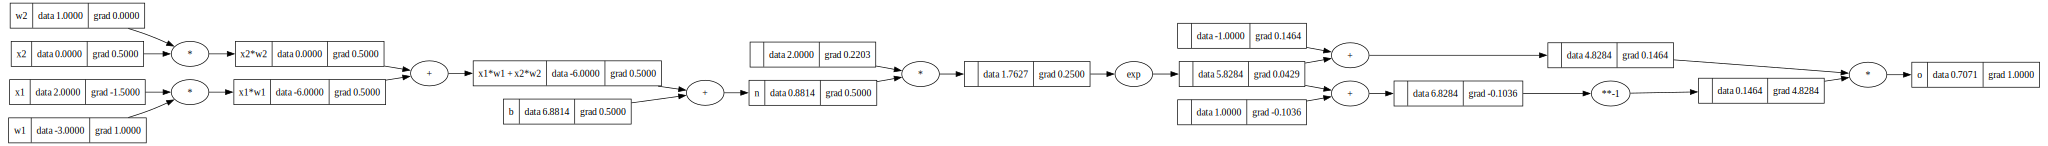

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [13]:
import torch

In [14]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6045819405987133)

In [17]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [18]:

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 9.13968577970062
1 3.2548100281562258
2 1.4384729669839686
3 0.6014517076773627
4 0.27303225830862127
5 0.15461146897850483
6 0.11422001187148492
7 0.08992120919549898
8 0.07382535868356313
9 0.06243484490188486
10 0.05397764532331106
11 0.047465437635927345
12 0.04230565190155541
13 0.038122391190793664
14 0.03466618241730397
15 0.031765210883764584
16 0.029297432730498993
17 0.0271738583539008
18 0.025328126220918512
19 0.02370977547589386


In [19]:
ypred

[Value(data=0.9339512382263988),
 Value(data=-0.9404589992701082),
 Value(data=-0.9094643669029507),
 Value(data=0.9127904539865764)]

# 🎮 Interactive Neural Network Visualizations!

Let's explore the neural network interactively!

In [26]:
# 1. Interactive Training Visualization with Learning Rate Control
import ipywidgets as widgets
from IPython.display import display, clear_output

def train_network_interactive(learning_rate=0.1, num_iterations=20):
    """Train the network and visualize the process"""
    
    # Create fresh network
    n = MLP(3, [4, 4, 1])
    
    # Dataset
    xs = [
        [2.0, 3.0, -1.0],
        [3.0, -1.0, 0.5],
        [0.5, 1.0, 1.0],
        [1.0, 1.0, -1.0],
    ]
    ys = [1.0, -1.0, -1.0, 1.0]
    
    losses = []
    predictions_over_time = []
    
    # Training loop
    for k in range(num_iterations):
        # Forward pass
        ypred = [n(x) for x in xs]
        loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
        
        losses.append(loss.data)
        predictions_over_time.append([y.data for y in ypred])
        
        # Backward pass
        for p in n.parameters():
            p.grad = 0.0
        loss.backward()
        
        # Update
        for p in n.parameters():
            p.data += -learning_rate * p.grad
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Loss over time
    axes[0].plot(losses, 'b-', linewidth=2, marker='o', markersize=6)
    axes[0].set_xlabel('Iteration', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'Training Loss (LR={learning_rate})', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_yscale('log')
    
    # Plot 2: Predictions evolution
    predictions_array = np.array(predictions_over_time)
    for i in range(4):
        axes[1].plot(predictions_array[:, i], label=f'Sample {i+1} (target={ys[i]})', 
                    linewidth=2, marker='o', markersize=4)
        axes[1].axhline(y=ys[i], color=f'C{i}', linestyle='--', alpha=0.3, linewidth=1)
    
    axes[1].set_xlabel('Iteration', fontsize=12)
    axes[1].set_ylabel('Prediction', fontsize=12)
    axes[1].set_title('Predictions Converging to Targets', fontsize=14, fontweight='bold')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Final predictions vs targets
    final_preds = predictions_array[-1, :]
    x_pos = np.arange(4)
    width = 0.35
    
    axes[2].bar(x_pos - width/2, ys, width, label='Target', alpha=0.7, color='green')
    axes[2].bar(x_pos + width/2, final_preds, width, label='Prediction', alpha=0.7, color='blue')
    axes[2].set_xlabel('Sample', fontsize=12)
    axes[2].set_ylabel('Value', fontsize=12)
    axes[2].set_title('Final: Target vs Prediction', fontsize=14, fontweight='bold')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels([f'S{i+1}' for i in range(4)])
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Training Summary (Learning Rate = {learning_rate})")
    print(f"{'='*60}")
    print(f"Initial Loss: {losses[0]:.6f}")
    print(f"Final Loss:   {losses[-1]:.6f}")
    print(f"Improvement:  {(1 - losses[-1]/losses[0])*100:.2f}%")
    print(f"\nFinal Predictions vs Targets:")
    for i in range(4):
        error = abs(final_preds[i] - ys[i])
        print(f"  Sample {i+1}: Pred={final_preds[i]:7.4f}, Target={ys[i]:5.1f}, Error={error:.4f}")

# Create interactive widget
lr_slider = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=0.5,
    step=0.01,
    description='Learning Rate:',
    continuous_update=False,
    style={'description_width': '120px'}
)

iter_slider = widgets.IntSlider(
    value=20,
    min=5,
    max=100,
    step=5,
    description='Iterations:',
    continuous_update=False,
    style={'description_width': '120px'}
)

train_button = widgets.Button(
    description='🚀 Train Network!',
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px')
)

output = widgets.Output()

def on_train_clicked(b):
    with output:
        clear_output(wait=True)
        train_network_interactive(lr_slider.value, iter_slider.value)

train_button.on_click(on_train_clicked)

print("🎮 Interactive Neural Network Training!")
print("Adjust learning rate and iterations, then click the button.\n")
display(lr_slider, iter_slider, train_button, output)

🎮 Interactive Neural Network Training!
Adjust learning rate and iterations, then click the button.



FloatSlider(value=0.1, continuous_update=False, description='Learning Rate:', max=0.5, min=0.01, step=0.01, st…

IntSlider(value=20, continuous_update=False, description='Iterations:', min=5, step=5, style=SliderStyle(descr…

Button(button_style='success', description='🚀 Train Network!', layout=Layout(height='40px', width='200px'), st…

Output()

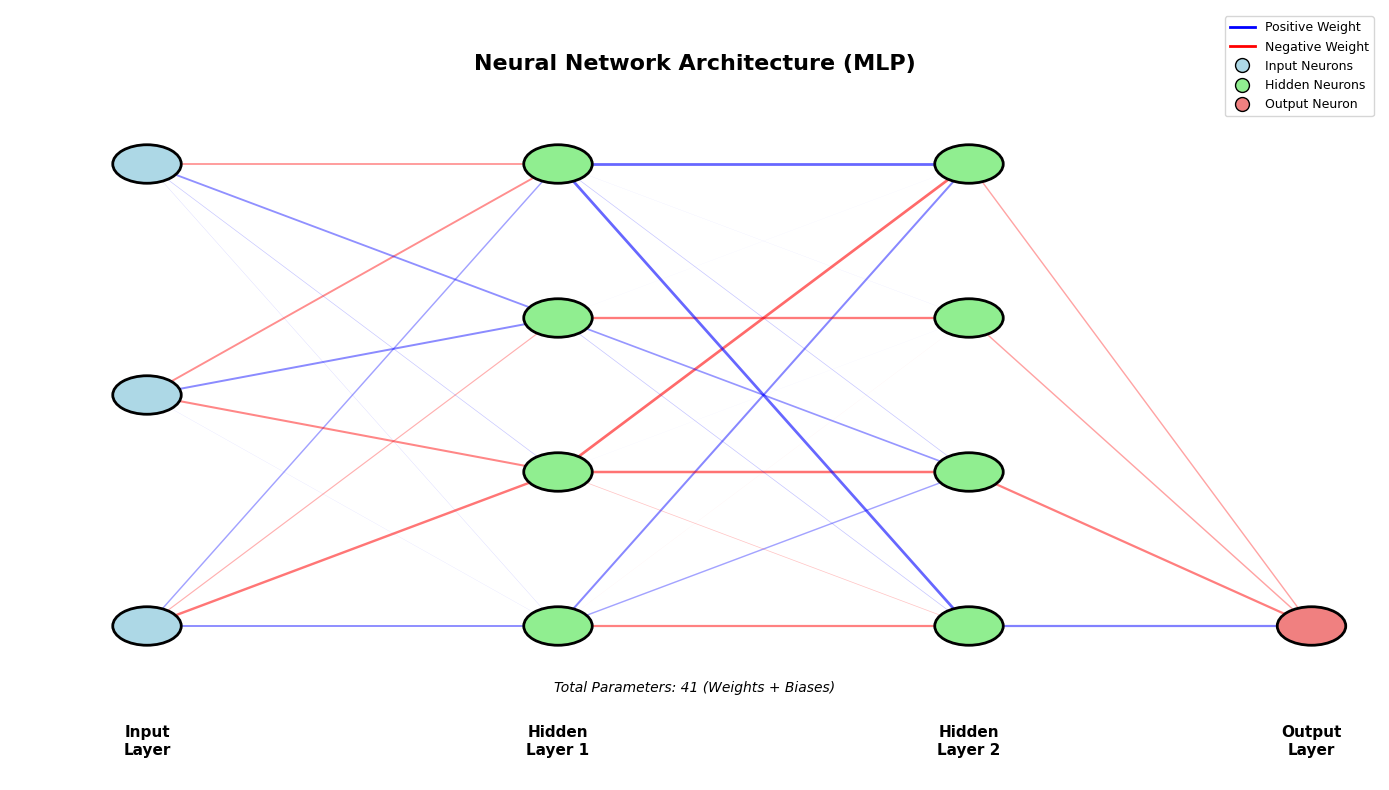

Network Structure: 3 → 4 → 4 → 1
Total neurons: 12
Total parameters: 41


In [27]:
# 2. Interactive Network Architecture Visualizer
def visualize_network_architecture():
    """Visualize the MLP architecture with weights"""
    
    # Create a network
    n = MLP(3, [4, 4, 1])
    
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Layer positions
    layers = [3, 4, 4, 1]  # Input, hidden1, hidden2, output
    layer_names = ['Input\nLayer', 'Hidden\nLayer 1', 'Hidden\nLayer 2', 'Output\nLayer']
    layer_x = [1, 4, 7, 9.5]
    
    # Draw neurons and connections
    neurons_pos = []
    
    for layer_idx, (num_neurons, x_pos) in enumerate(zip(layers, layer_x)):
        y_positions = np.linspace(2, 8, num_neurons)
        neurons_pos.append([(x_pos, y) for y in y_positions])
        
        # Draw neurons
        for y_pos in y_positions:
            circle = plt.Circle((x_pos, y_pos), 0.25, 
                              color='lightblue' if layer_idx == 0 else 'lightcoral' if layer_idx == len(layers)-1 else 'lightgreen',
                              ec='black', linewidth=2, zorder=3)
            ax.add_patch(circle)
        
        # Add layer label
        ax.text(x_pos, 0.5, layer_names[layer_idx], 
               ha='center', va='center', fontsize=11, fontweight='bold')
    
    # Draw connections with weight-based coloring
    param_idx = 0
    params = n.parameters()
    
    for layer_idx in range(len(layers) - 1):
        for i, (x1, y1) in enumerate(neurons_pos[layer_idx]):
            for j, (x2, y2) in enumerate(neurons_pos[layer_idx + 1]):
                # Get weight value
                weight = params[param_idx].data
                param_idx += 1
                
                # Color based on weight (red=negative, blue=positive)
                color = 'red' if weight < 0 else 'blue'
                alpha = min(abs(weight), 1.0) * 0.5 + 0.1
                width = min(abs(weight) * 2, 3)
                
                ax.plot([x1, x2], [y1, y2], color=color, alpha=alpha, 
                       linewidth=width, zorder=1)
    
    # Add title and info
    ax.text(5, 9.3, 'Neural Network Architecture (MLP)', 
           ha='center', va='center', fontsize=16, fontweight='bold')
    
    ax.text(5, 1.2, f'Total Parameters: {len(params)} (Weights + Biases)', 
           ha='center', va='center', fontsize=10, style='italic')
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Positive Weight'),
        Line2D([0], [0], color='red', lw=2, label='Negative Weight'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
               markersize=10, label='Input Neurons', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', 
               markersize=10, label='Hidden Neurons', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', 
               markersize=10, label='Output Neuron', markeredgecolor='black'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Network Structure: {layers[0]} → {layers[1]} → {layers[2]} → {layers[3]}")
    print(f"Total neurons: {sum(layers)}")
    print(f"Total parameters: {len(params)}")

visualize_network_architecture()

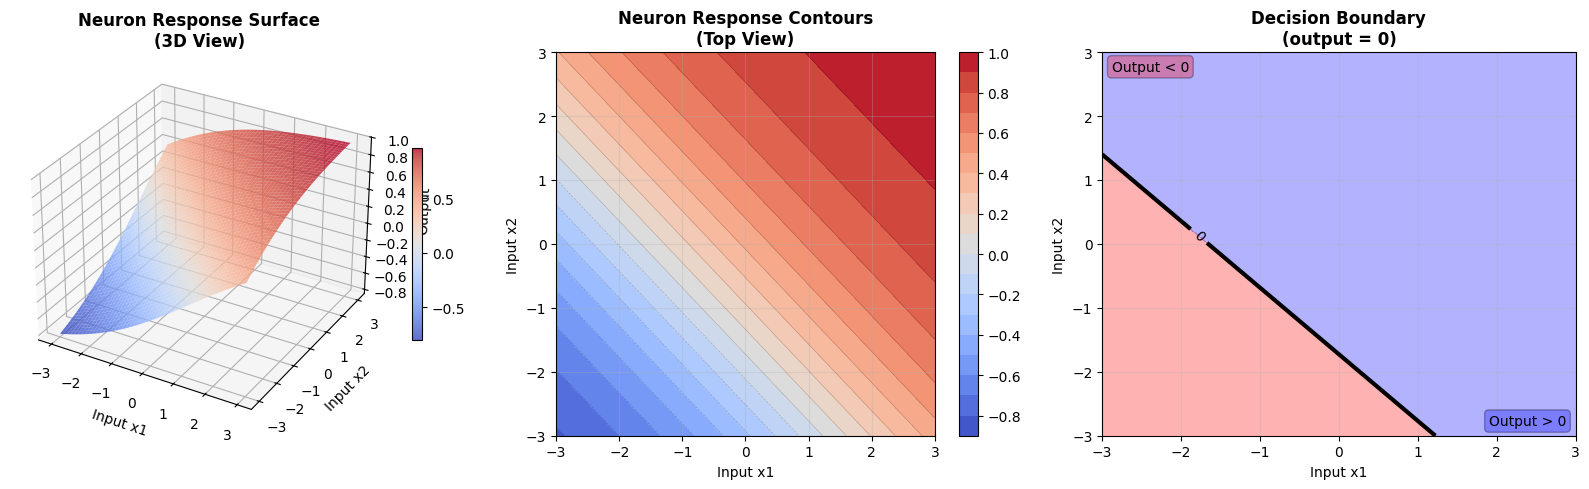


Single Neuron Analysis
Activation Function: tanh
Number of inputs: 2
Weights: w1=0.2689, w2=0.2581
Bias: b=0.4455

Neuron equation: output = tanh(w1*x1 + w2*x2 + b)
Output range: [-1, 1]


In [29]:
# 3. Interactive Neuron Explorer - See how a single neuron responds to inputs!
def explore_single_neuron_interactive():
    """Explore how a single neuron behaves with different inputs"""
    
    neuron = Neuron(2)  # 2 inputs
    
    # Create grid of inputs
    x1_range = np.linspace(-3, 3, 50)
    x2_range = np.linspace(-3, 3, 50)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    # Compute neuron output for each input pair
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            output = neuron([X1[i, j], X2[i, j]])
            Z[i, j] = output.data
    
    # Create visualization
    fig = plt.figure(figsize=(16, 5))
    
    # 3D Surface plot
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(X1, X2, Z, cmap='coolwarm', alpha=0.8, edgecolor='none')
    ax1.set_xlabel('Input x1', fontsize=10)
    ax1.set_ylabel('Input x2', fontsize=10)
    ax1.set_zlabel('Output', fontsize=10)
    ax1.set_title('Neuron Response Surface\n(3D View)', fontsize=12, fontweight='bold')
    fig.colorbar(surf, ax=ax1, shrink=0.5)
    
    # Contour plot
    ax2 = fig.add_subplot(132)
    contour = ax2.contourf(X1, X2, Z, levels=20, cmap='coolwarm')
    ax2.contour(X1, X2, Z, levels=20, colors='black', alpha=0.2, linewidths=0.5)
    ax2.set_xlabel('Input x1', fontsize=10)
    ax2.set_ylabel('Input x2', fontsize=10)
    ax2.set_title('Neuron Response Contours\n(Top View)', fontsize=12, fontweight='bold')
    fig.colorbar(contour, ax=ax2)
    ax2.grid(True, alpha=0.3)
    
    # Decision boundary (where output = 0)
    ax3 = fig.add_subplot(133)
    contour3 = ax3.contourf(X1, X2, Z, levels=[-1, 0, 1], colors=['red', 'blue'], alpha=0.3)
    cs = ax3.contour(X1, X2, Z, levels=[0], colors='black', linewidths=3)
    ax3.clabel(cs, inline=True, fontsize=10)
    ax3.set_xlabel('Input x1', fontsize=10)
    ax3.set_ylabel('Input x2', fontsize=10)
    ax3.set_title('Decision Boundary\n(output = 0)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Add text labels
    ax3.text(0.02, 0.98, 'Output < 0', transform=ax3.transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='red', alpha=0.3))
    ax3.text(0.98, 0.02, 'Output > 0', transform=ax3.transAxes,
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Print neuron info
    print(f"\n{'='*60}")
    print(f"Single Neuron Analysis")
    print(f"{'='*60}")
    print(f"Activation Function: tanh")
    print(f"Number of inputs: 2")
    print(f"Weights: w1={neuron.w[0].data:.4f}, w2={neuron.w[1].data:.4f}")
    print(f"Bias: b={neuron.b.data:.4f}")
    print(f"\nNeuron equation: output = tanh(w1*x1 + w2*x2 + b)")
    print(f"Output range: [-1, 1]")

explore_single_neuron_interactive()

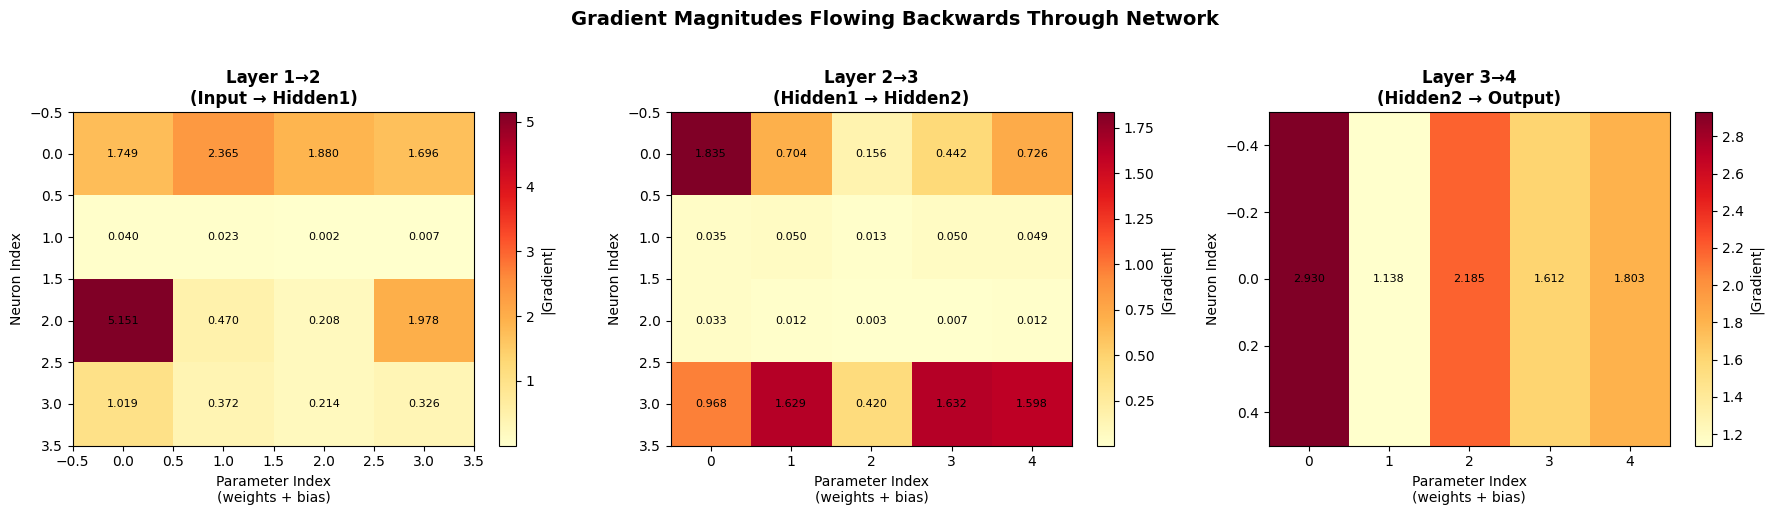


Gradient Flow Statistics
Total parameters: 41
Mean gradient magnitude: 0.915676
Max gradient magnitude: 5.151436
Min gradient magnitude: 0.002020
Std gradient magnitude: 1.068858

✅ Gradients are in healthy range!


In [30]:
# 4. Interactive Gradient Flow Visualization Through Network Layers
def visualize_gradient_flow(sample_idx=0):
    """Visualize how gradients flow backwards through the network"""
    
    # Train a network first
    n = MLP(3, [4, 4, 1])
    xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
    ys = [1.0, -1.0, -1.0, 1.0]
    
    # Single training step
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # Collect gradients per layer
    params = n.parameters()
    layer_sizes = [3, 4, 4, 1]
    
    # Calculate parameter indices for each layer
    layer_gradients = []
    idx = 0
    for i in range(len(layer_sizes) - 1):
        layer_params = []
        # Weights
        for _ in range(layer_sizes[i+1]):
            neuron_grads = []
            for _ in range(layer_sizes[i]):
                neuron_grads.append(abs(params[idx].grad))
                idx += 1
            # Bias
            neuron_grads.append(abs(params[idx].grad))
            idx += 1
            layer_params.append(neuron_grads)
        layer_gradients.append(layer_params)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    layer_names = ['Layer 1→2\n(Input → Hidden1)', 'Layer 2→3\n(Hidden1 → Hidden2)', 
                   'Layer 3→4\n(Hidden2 → Output)']
    
    for ax_idx, (ax, layer_grads, name) in enumerate(zip(axes, layer_gradients, layer_names)):
        # Convert to array for heatmap
        max_len = max(len(g) for g in layer_grads)
        grad_array = np.zeros((len(layer_grads), max_len))
        
        for i, neuron_grads in enumerate(layer_grads):
            for j, grad_val in enumerate(neuron_grads):
                grad_array[i, j] = grad_val
        
        im = ax.imshow(grad_array, cmap='YlOrRd', aspect='auto')
        ax.set_title(name, fontsize=12, fontweight='bold')
        ax.set_xlabel('Parameter Index\n(weights + bias)', fontsize=10)
        ax.set_ylabel('Neuron Index', fontsize=10)
        
        # Add gradient values as text
        for i in range(grad_array.shape[0]):
            for j in range(grad_array.shape[1]):
                if grad_array[i, j] > 0:
                    text = ax.text(j, i, f'{grad_array[i, j]:.3f}',
                                 ha="center", va="center", color="black", fontsize=8)
        
        plt.colorbar(im, ax=ax, label='|Gradient|')
    
    plt.suptitle('Gradient Magnitudes Flowing Backwards Through Network', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    all_grads = [abs(p.grad) for p in params]
    print(f"\n{'='*60}")
    print(f"Gradient Flow Statistics")
    print(f"{'='*60}")
    print(f"Total parameters: {len(params)}")
    print(f"Mean gradient magnitude: {np.mean(all_grads):.6f}")
    print(f"Max gradient magnitude: {np.max(all_grads):.6f}")
    print(f"Min gradient magnitude: {np.min(all_grads):.6f}")
    print(f"Std gradient magnitude: {np.std(all_grads):.6f}")
    
    # Check for vanishing/exploding gradients
    if np.max(all_grads) > 10:
        print(f"\n⚠️  Warning: Large gradients detected! (exploding gradients)")
    elif np.mean(all_grads) < 0.0001:
        print(f"\n⚠️  Warning: Very small gradients! (vanishing gradients)")
    else:
        print(f"\n✅ Gradients are in healthy range!")

visualize_gradient_flow()

In [31]:
# 5. Interactive Weight Space Exploration - Adjust weights and see predictions change!
def create_weight_explorer():
    """Interactive widget to explore how weights affect predictions"""
    
    # Create a simple network
    neuron = Neuron(2)
    
    # Fixed test input
    test_input = [1.0, 1.0]
    
    def update_plot(w1, w2, bias):
        # Update neuron weights
        neuron.w[0].data = w1
        neuron.w[1].data = w2
        neuron.b.data = bias
        
        # Create grid for visualization
        x1_range = np.linspace(-2, 2, 40)
        x2_range = np.linspace(-2, 2, 40)
        X1, X2 = np.meshgrid(x1_range, x2_range)
        
        # Compute outputs
        Z = np.zeros_like(X1)
        for i in range(X1.shape[0]):
            for j in range(X1.shape[1]):
                output = neuron([X1[i, j], X2[i, j]])
                Z[i, j] = output.data
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Contour plot
        contour = ax1.contourf(X1, X2, Z, levels=20, cmap='RdYlBu_r')
        ax1.contour(X1, X2, Z, levels=[0], colors='black', linewidths=3)
        ax1.plot(test_input[0], test_input[1], 'r*', markersize=20, 
                label=f'Test Input ({test_input[0]}, {test_input[1]})')
        ax1.set_xlabel('x1', fontsize=12)
        ax1.set_ylabel('x2', fontsize=12)
        ax1.set_title('Neuron Response Landscape', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        plt.colorbar(contour, ax=ax1, label='Output')
        
        # Test output
        test_output = neuron(test_input)
        ax2.bar(['Output'], [test_output.data], color='steelblue', alpha=0.7, width=0.4)
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
        ax2.set_ylim(-1.5, 1.5)
        ax2.set_ylabel('Value', fontsize=12)
        ax2.set_title(f'Test Input Output: {test_output.data:.4f}', 
                     fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add equation
        equation = f'output = tanh({w1:.2f}*x1 + {w2:.2f}*x2 + {bias:.2f})'
        ax2.text(0.5, 0.95, equation, transform=ax2.transAxes,
                ha='center', va='top', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
    
    # Create sliders
    w1_slider = widgets.FloatSlider(value=neuron.w[0].data, min=-3, max=3, step=0.1, 
                                     description='Weight w1:', continuous_update=False)
    w2_slider = widgets.FloatSlider(value=neuron.w[1].data, min=-3, max=3, step=0.1, 
                                     description='Weight w2:', continuous_update=False)
    bias_slider = widgets.FloatSlider(value=neuron.b.data, min=-3, max=3, step=0.1, 
                                       description='Bias b:', continuous_update=False)
    
    # Interactive output
    out = widgets.interactive_output(update_plot, {
        'w1': w1_slider,
        'w2': w2_slider,
        'bias': bias_slider
    })
    
    # Display
    print("🎮 Interactive Weight Explorer")
    print("Adjust the sliders to see how weights affect the neuron's behavior!\n")
    display(widgets.VBox([w1_slider, w2_slider, bias_slider]), out)

create_weight_explorer()

🎮 Interactive Weight Explorer
Adjust the sliders to see how weights affect the neuron's behavior!



Output()

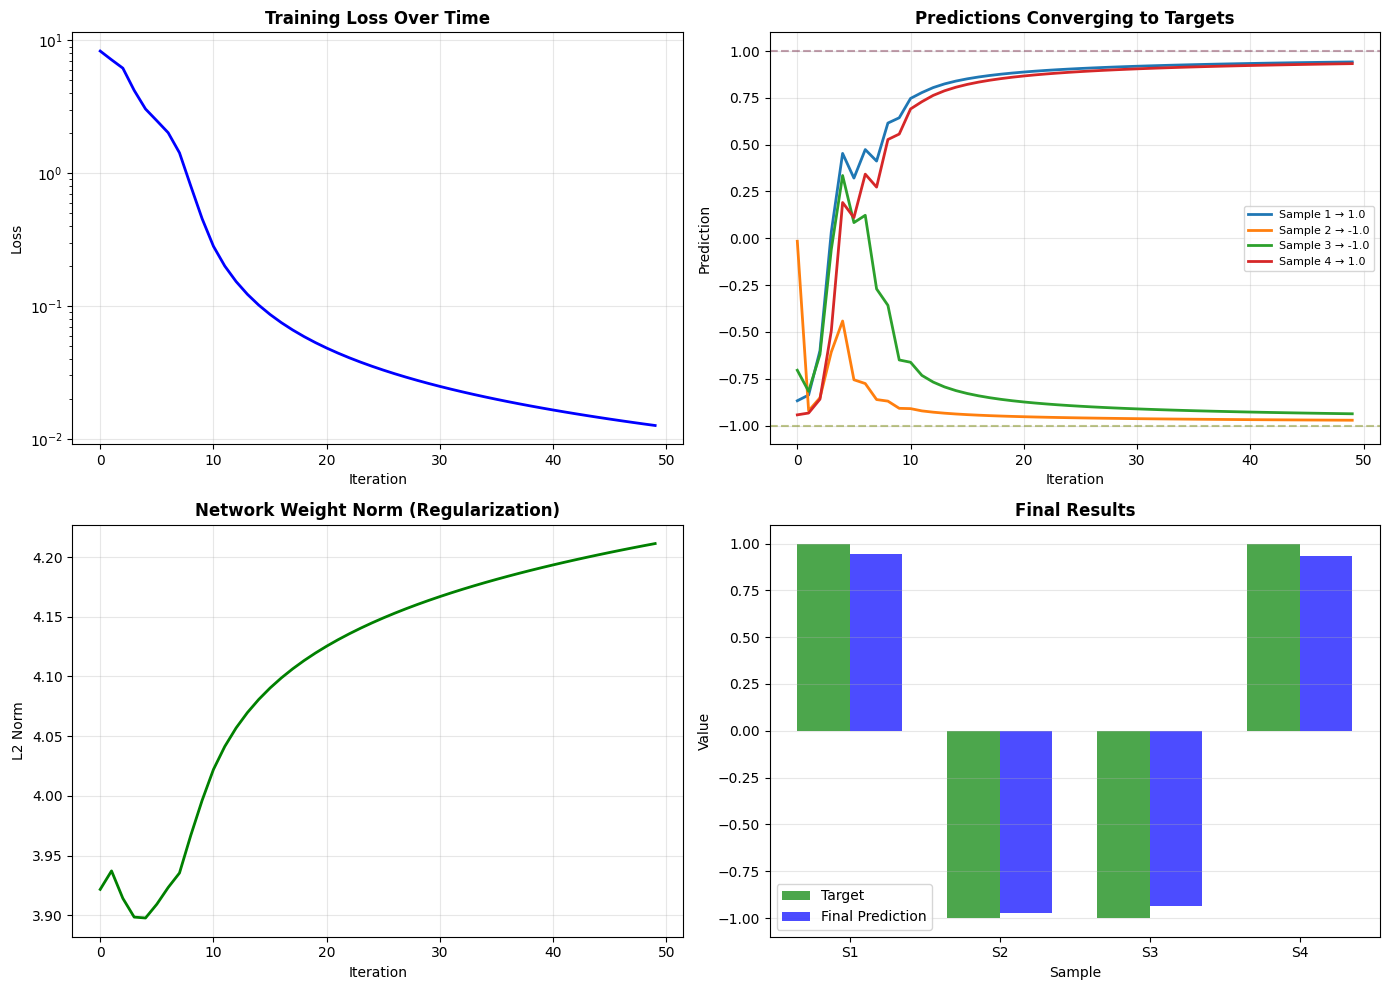


Training Complete! 🎉
Total Iterations: 50
Initial Loss: 8.320534
Final Loss: 0.012602
Loss Reduction: 99.85%

Final Predictions:
  Sample 1:  0.9419 (target:   1.0) | Error: 0.0581
  Sample 2: -0.9718 (target:  -1.0) | Error: 0.0282
  Sample 3: -0.9374 (target:  -1.0) | Error: 0.0626
  Sample 4:  0.9328 (target:   1.0) | Error: 0.0672

Final Weight Norm: 4.2113


In [32]:
# 6. Training Animation - Watch the network learn in real-time!
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def create_training_animation():
    """Create an animated visualization of the training process"""
    
    # Setup
    n = MLP(3, [4, 4, 1])
    xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
    ys = [1.0, -1.0, -1.0, 1.0]
    learning_rate = 0.05
    
    # Storage for animation
    history = {'losses': [], 'predictions': [], 'weights_norm': []}
    
    # Training loop and collect data
    for k in range(50):
        # Forward
        ypred = [n(x) for x in xs]
        loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
        
        # Store
        history['losses'].append(loss.data)
        history['predictions'].append([y.data for y in ypred])
        
        # Calculate weight norm
        weight_norm = sum(p.data**2 for p in n.parameters())**0.5
        history['weights_norm'].append(weight_norm)
        
        # Backward
        for p in n.parameters():
            p.grad = 0.0
        loss.backward()
        
        # Update
        for p in n.parameters():
            p.data += -learning_rate * p.grad
    
    # Create static visualization with all data
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Loss
    axes[0, 0].plot(history['losses'], 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss Over Time', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # Plot 2: Predictions evolution
    predictions_array = np.array(history['predictions'])
    for i in range(4):
        axes[0, 1].plot(predictions_array[:, i], label=f'Sample {i+1} → {ys[i]}', linewidth=2)
        axes[0, 1].axhline(y=ys[i], color=f'C{i}', linestyle='--', alpha=0.3)
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Prediction')
    axes[0, 1].set_title('Predictions Converging to Targets', fontweight='bold')
    axes[0, 1].legend(loc='best', fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Weight norm
    axes[1, 0].plot(history['weights_norm'], 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('L2 Norm')
    axes[1, 0].set_title('Network Weight Norm (Regularization)', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Final comparison
    final_preds = predictions_array[-1, :]
    x_pos = np.arange(4)
    width = 0.35
    axes[1, 1].bar(x_pos - width/2, ys, width, label='Target', alpha=0.7, color='green')
    axes[1, 1].bar(x_pos + width/2, final_preds, width, label='Final Prediction', 
                   alpha=0.7, color='blue')
    axes[1, 1].set_xlabel('Sample')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].set_title('Final Results', fontweight='bold')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([f'S{i+1}' for i in range(4)])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"Training Complete! 🎉")
    print(f"{'='*70}")
    print(f"Total Iterations: {len(history['losses'])}")
    print(f"Initial Loss: {history['losses'][0]:.6f}")
    print(f"Final Loss: {history['losses'][-1]:.6f}")
    print(f"Loss Reduction: {(1 - history['losses'][-1]/history['losses'][0])*100:.2f}%")
    print(f"\nFinal Predictions:")
    for i in range(4):
        print(f"  Sample {i+1}: {final_preds[i]:7.4f} (target: {ys[i]:5.1f}) | Error: {abs(final_preds[i] - ys[i]):.4f}")
    print(f"\nFinal Weight Norm: {history['weights_norm'][-1]:.4f}")

create_training_animation()

In [33]:
# 7. Interactive Computation Graph Explorer with Backward Pass Step-by-Step
def explore_computation_graph_interactive():
    """Step through backward pass interactively"""
    
    # Create a simple computation
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    b = Value(6.88, label='b')
    
    x1w1 = x1 * w1; x1w1.label = 'x1*w1'
    x2w2 = x2 * w2; x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    o = n.tanh(); o.label = 'o'
    
    # Manual backward pass step by step
    nodes = [o, n, x1w1x2w2, b, x2w2, x1w1, w2, x2, w1, x1]
    node_names = ['Output (o)', 'Pre-activation (n)', 'Sum (x1w1+x2w2)', 
                  'Bias (b)', 'x2*w2', 'x1*w1', 'w2', 'x2', 'w1', 'x1']
    
    def show_step(step):
        # Reset all gradients
        for node in nodes:
            node.grad = 0.0
        
        # Perform backward pass up to current step
        o.grad = 1.0
        
        if step >= 1:  # o -> n
            n.grad = (1 - o.data**2) * o.grad
        if step >= 2:  # n -> x1w1x2w2 and b
            x1w1x2w2.grad = 1.0 * n.grad
            b.grad = 1.0 * n.grad
        if step >= 3:  # x1w1x2w2 -> x1w1 and x2w2
            x1w1.grad = 1.0 * x1w1x2w2.grad
            x2w2.grad = 1.0 * x1w1x2w2.grad
        if step >= 4:  # x1w1 -> x1 and w1
            x1.grad = w1.data * x1w1.grad
            w1.grad = x1.data * x1w1.grad
        if step >= 5:  # x2w2 -> x2 and w2
            x2.grad = w2.data * x2w2.grad
            w2.grad = x2.data * x2w2.grad
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Node values and gradients table
        ax1.axis('tight')
        ax1.axis('off')
        
        table_data = []
        for i, (node, name) in enumerate(zip(nodes, node_names)):
            grad_text = f"{node.grad:.4f}" if step > 0 else "—"
            color = 'lightgreen' if node.grad != 0.0 else 'white'
            
            if i <= step:
                table_data.append([name, f"{node.data:.4f}", grad_text])
            else:
                table_data.append([name, f"{node.data:.4f}", "—"])
        
        table = ax1.table(cellText=table_data, 
                         colLabels=['Node', 'Value (data)', 'Gradient (∂L/∂node)'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.4, 0.3, 0.3])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # Color the active rows
        for i in range(min(step + 1, len(nodes))):
            table[(i+1, 0)].set_facecolor('lightgreen')
            table[(i+1, 1)].set_facecolor('lightgreen')
            table[(i+1, 2)].set_facecolor('lightgreen')
        
        ax1.set_title(f'Backward Pass - Step {step}/{len(nodes)-1}', 
                     fontsize=14, fontweight='bold', pad=20)
        
        # Right: Gradient flow diagram
        ax2.axis('off')
        ax2.set_xlim(0, 10)
        ax2.set_ylim(0, 12)
        
        # Draw gradient flow arrows
        flow_text = [
            "o.grad = 1.0  [Start]",
            "n.grad = (1 - o²) * o.grad",
            "x1w1x2w2.grad = n.grad",
            "b.grad = n.grad",
            "x1w1.grad = x1w1x2w2.grad",
            "w1.grad = x1 * x1w1.grad",
            "x1.grad = w1 * x1w1.grad"
        ]
        
        y_pos = 11
        for i, text in enumerate(flow_text[:min(step+1, len(flow_text))]):
            ax2.text(0.5, y_pos, f"Step {i}: {text}", fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
            if i < len(flow_text) - 1:
                ax2.arrow(0.5, y_pos - 0.3, 0, -0.4, head_width=0.3, 
                         head_length=0.2, fc='blue', ec='blue')
            y_pos -= 1.5
        
        ax2.set_title('Gradient Flow (Backpropagation)', 
                     fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive slider
    step_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=5,
        step=1,
        description='Backprop Step:',
        continuous_update=False,
        style={'description_width': '120px'}
    )
    
    out = widgets.interactive_output(show_step, {'step': step_slider})
    
    print("🔍 Interactive Computation Graph Explorer")
    print("Step through the backward pass one operation at a time!\n")
    display(step_slider, out)

explore_computation_graph_interactive()

🔍 Interactive Computation Graph Explorer
Step through the backward pass one operation at a time!



IntSlider(value=0, continuous_update=False, description='Backprop Step:', max=5, style=SliderStyle(description…

Output()

## 🎉 Summary: Interactive Visualizations Added!

We've added 7 powerful interactive visualizations to explore neural networks:

1. **🚀 Interactive Training Control** - Adjust learning rate and iterations with sliders, train with a button click
2. **🧠 Network Architecture Visualizer** - See the complete MLP structure with color-coded weights
3. **🔬 Single Neuron Explorer** - Explore how individual neurons respond to inputs (3D surface, contours, decision boundaries)
4. **📊 Gradient Flow Heatmaps** - Visualize gradient magnitudes flowing backwards through each layer
5. **⚙️ Weight Space Explorer** - Interactive sliders to adjust weights and see real-time prediction changes
6. **📈 Training Animation** - Watch loss decrease, predictions converge, and weight norms evolve over time
7. **🔍 Computation Graph Step-by-Step** - Step through backpropagation one operation at a time

These visualizations help understand:
- How gradient descent works
- How weights affect predictions
- How gradients flow backwards through layers
- The training dynamics of neural networks
- The computation graph and backpropagation process

**All visualizations use the same Value class and MLP implementation from the lecture!** 🎓

In [34]:
# 8. Interactive Graphviz Computation Graph - Adjust inputs/weights and see the graph update!
def create_interactive_computation_graph():
    """Interactive computation graph with sliders for inputs and weights"""
    
    def update_graph(x1_val, x2_val, w1_val, w2_val, b_val):
        # Create computation with current values
        x1 = Value(x1_val, label='x1')
        x2 = Value(x2_val, label='x2')
        w1 = Value(w1_val, label='w1')
        w2 = Value(w2_val, label='w2')
        b = Value(b_val, label='b')
        
        # Forward pass
        x1w1 = x1 * w1; x1w1.label = 'x1*w1'
        x2w2 = x2 * w2; x2w2.label = 'x2*w2'
        x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
        n = x1w1x2w2 + b; n.label = 'n'
        o = n.tanh(); o.label = 'o'
        
        # Backward pass
        o.backward()
        
        # Draw the graph
        graph = draw_dot(o)
        
        # Display the graph
        display(graph)
        
        # Print summary
        print(f"\n{'='*70}")
        print(f"📊 Computation Summary")
        print(f"{'='*70}")
        print(f"\n🔵 Forward Pass (Data):")
        print(f"  x1 = {x1.data:.4f}")
        print(f"  x2 = {x2.data:.4f}")
        print(f"  w1 = {w1.data:.4f}")
        print(f"  w2 = {w2.data:.4f}")
        print(f"  b  = {b.data:.4f}")
        print(f"  ───────────────────")
        print(f"  x1*w1 = {x1w1.data:.4f}")
        print(f"  x2*w2 = {x2w2.data:.4f}")
        print(f"  x1*w1 + x2*w2 = {x1w1x2w2.data:.4f}")
        print(f"  n = x1*w1 + x2*w2 + b = {n.data:.4f}")
        print(f"  o = tanh(n) = {o.data:.4f}")
        
        print(f"\n🔴 Backward Pass (Gradients):")
        print(f"  ∂o/∂o = {o.grad:.4f}")
        print(f"  ∂o/∂n = {n.grad:.4f}")
        print(f"  ∂o/∂b = {b.grad:.4f}")
        print(f"  ∂o/∂(x1*w1+x2*w2) = {x1w1x2w2.grad:.4f}")
        print(f"  ∂o/∂(x1*w1) = {x1w1.grad:.4f}")
        print(f"  ∂o/∂(x2*w2) = {x2w2.grad:.4f}")
        print(f"  ∂o/∂w1 = {w1.grad:.4f}")
        print(f"  ∂o/∂w2 = {w2.grad:.4f}")
        print(f"  ∂o/∂x1 = {x1.grad:.4f}")
        print(f"  ∂o/∂x2 = {x2.grad:.4f}")
        
        # Gradient descent suggestion
        learning_rate = 0.1
        print(f"\n💡 Gradient Descent Update (lr={learning_rate}):")
        print(f"  w1_new = {w1.data:.4f} - {learning_rate} * {w1.grad:.4f} = {w1.data - learning_rate * w1.grad:.4f}")
        print(f"  w2_new = {w2.data:.4f} - {learning_rate} * {w2.grad:.4f} = {w2.data - learning_rate * w2.grad:.4f}")
        print(f"  b_new  = {b.data:.4f} - {learning_rate} * {b.grad:.4f} = {b.data - learning_rate * b.grad:.4f}")
    
    # Create sliders for inputs
    x1_slider = widgets.FloatSlider(
        value=2.0, min=-5, max=5, step=0.1,
        description='Input x1:',
        continuous_update=False,
        style={'description_width': '100px'}
    )
    
    x2_slider = widgets.FloatSlider(
        value=0.0, min=-5, max=5, step=0.1,
        description='Input x2:',
        continuous_update=False,
        style={'description_width': '100px'}
    )
    
    # Create sliders for weights
    w1_slider = widgets.FloatSlider(
        value=-3.0, min=-5, max=5, step=0.1,
        description='Weight w1:',
        continuous_update=False,
        style={'description_width': '100px'}
    )
    
    w2_slider = widgets.FloatSlider(
        value=1.0, min=-5, max=5, step=0.1,
        description='Weight w2:',
        continuous_update=False,
        style={'description_width': '100px'}
    )
    
    b_slider = widgets.FloatSlider(
        value=6.88, min=-10, max=10, step=0.1,
        description='Bias b:',
        continuous_update=False,
        style={'description_width': '100px'}
    )
    
    # Update button
    update_button = widgets.Button(
        description='🔄 Update Graph!',
        button_style='info',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    output = widgets.Output()
    
    def on_update_clicked(b):
        with output:
            clear_output(wait=True)
            update_graph(x1_slider.value, x2_slider.value, 
                        w1_slider.value, w2_slider.value, b_slider.value)
    
    update_button.on_click(on_update_clicked)
    
    # Initial display
    print("🎮 Interactive Computation Graph with Graphviz!")
    print("Adjust the sliders and click 'Update Graph' to see the computation tree.\n")
    print("The graph shows:")
    print("  • Node values (forward pass)")
    print("  • Gradients (backward pass)")
    print("  • Operations (+, *, tanh)\n")
    
    display(
        widgets.VBox([
            widgets.HTML("<h3>📥 Inputs</h3>"),
            x1_slider,
            x2_slider,
            widgets.HTML("<h3>⚙️ Parameters</h3>"),
            w1_slider,
            w2_slider,
            b_slider,
            widgets.HTML("<br>"),
            update_button
        ]),
        output
    )
    
    # Show initial graph
    with output:
        update_graph(x1_slider.value, x2_slider.value, 
                    w1_slider.value, w2_slider.value, b_slider.value)

create_interactive_computation_graph()

🎮 Interactive Computation Graph with Graphviz!
Adjust the sliders and click 'Update Graph' to see the computation tree.

The graph shows:
  • Node values (forward pass)
  • Gradients (backward pass)
  • Operations (+, *, tanh)



Output()